In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import warnings
from scipy import misc
from tqdm import tqdm

In [2]:
# Display function for CIFAR-10
def display(image):
    plt.imshow(misc.toimage(image.reshape((3, 32, 32)).transpose(1,2,0)), interpolation = 'gaussian')
    plt.show()

In [3]:
data_directory_path = './Datasets/cifar-10-batches-py'

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
def loadBatch(filepath):
    """
    Loads the input data from the CIFAR-10 file given by filepath, encodes
    the labels given by scalars into hot key encoding vectors and returns
    the (X, Y, y) tuple where X is the inputs, Y the hotkey encodings and
    y and scalar labels.
    """
    dataset = unpickle(filepath)
    dataSamples = dataset[b'data'] / 255
    labels = dataset[b'labels']
    label_count = np.max(labels)
    hotKeyEncodings = np.array([[0 if labels[i] != j else 1 for j in range(label_count + 1)] for i in range(len(labels))])
    return dataSamples, hotKeyEncodings, labels

In [77]:
class Params:
    """
    Class containing hyperparameters used for
    gradient descent learning.
    
    Attributes:
        n_batch: Number of samples in each mini-batch.
        eta: Learning rate
        n_epochs: Maximum number of learning epochs.
        decay_rate: The percentage of the original value of the learning rate
            which dictates the values of the learning rate once all epochs are
            completed.
        patience: Number of epochs the learning continues without increasing the 
            validation set accuracy before early stopping.
        tol: Any percentage of increase in accuracy lower than that is deemed
            insignificant.
    """
    def __init__(self, n_batch, eta, n_epochs, decay_rate = 1.0, patience = 1e+10, tol = 1e-4):
        """ Constructor """
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs
        self.decay_rate = decay_rate
        self.patience = patience
        self.tol = tol

In [73]:
class FeedforwardNet():
    """
    A single layer feedforward neural net implemention with
    a linear activation function, cross entropy loss and a 
    softmax output layer.
    
    Attributes:
        K: dimensons of output
        d: dimensions of input
        W: A Kxd matrix with the weights of the neural network.
        b: An 1xd vector with the bias values of each neuron.
    """
    
    
    def __init__(self, d, K, mean, s):
        """
        Initializes the Weight matrix and the bias vector
        with a Gaussian distribution.

        Args:
            d: input dimensions
            K: output dimensions
            mean: mean of Gaussian
            s: standard deviation of Gaussian

        Returns:
            A tuple with the weight matrix W and the bias vector b
            in this order.
        """
        self.K = K
        self.d = d
        self.W = np.random.normal(mean, s, (K, d)) # Weight matrix
        self.b = np.random.normal(mean, s, (K, 1)) # Bias vector
        
    def evaluateClassifier(self, X):
        """
        Evaluates the output of the classifier given the weights,
        the bias and the inputs.

        Args:
            X: An Nxd matrix with the N d-dimensional input samples.

        Returns:
            The  Kx1 output vector of the neural network passed through
            the softmax activation function.
        """
        s = np.dot(self.W, X.T) + self.b
        return self.softmax(s)

    def softmax(self, s):
        """
        Implementation of the softmax activation function

        Args:
            s: an 1xd vector of a classifier's outputs

        Returns:
            An 1xd vector with the results of softmax given the input
            vector s.
        """
        exponents = np.exp(s - np.max(s, axis = 0)) # Max subtraction for numerical stability
        output_exp_sum = np.sum(exponents, axis = 0)
        p = exponents / output_exp_sum
        return p


    def computeCost(self, X, Y, lamda, scale_const = 1e+6):
        """
        Evaluates the loss function of the network.

        Args:
            X: Input matrix
            Y: Output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.
            scale_const: constant used to temporarily scale up possibly 
                small floating point numbers to avoid precision errors caused
                by summing a lot of small numbers.
        Returns:
            A scalar corresponding to the loss.
        """
        return np.mean(scale_const * self.cross_entropy_loss(X, Y)) / scale_const \
                + lamda * np.sum(scale_const * np.power(self.W, 2)) / scale_const

    def cross_entropy_loss(self, X, Y):
        """
        Calculates the cross entropy loss
        """
        log_X = np.multiply(Y.T , self.evaluateClassifier(X)).sum(axis=0)
        log_X[log_X == 0] = np.finfo(float).eps
        return -np.log(log_X)
        

    def computeAccuracy(self, X, y):
        """
        Computes the accuracy of the network.

        Args:
            X: Input matrix
            y: Output labels
            
        Returns:
            The accuracy of the network (i.e. the percentage of
            correctly classified inputs in X).

        """
        softmax_outputs = self.evaluateClassifier(X) # Get probability distribution of outputs
        # Reduce to a vector of the labels with the highest probability
        predictions = np.argmax(softmax_outputs, axis = 0)
        accuracy = (predictions == y).mean()
        return accuracy    

    def computeGradients(self, X, Y, lamda, method = "analytical"):
        """
        Computes the gradient of the error with the regularization
        term with respect to the weights and the bias.

         Args:
            X: Input matrix
            Y: Desired output matrix
            lambda: Constant that determines the amount
                of loss induced by the regularization term.
            method: Type of method to be used to evaluate the gradients.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """
        
        P = self.evaluateClassifier(X)
        
        if method == "analytical":
            # Analytical computation of the gradient
            return self.computeAnalyticalGradients(X, Y, P, lamda)
        elif method == "fast_numerical":
            # Faster but less accurate calculation of the gradients
            return self.computeGradsNum(X, Y, P, lamda)
        elif method == "accurate_numerical":
            # More exact calculation of the gradients but slower
            return self.computeGradsNumSlow(X, Y, P, lamda)


    def computeGradsNum(self, X, Y, P, lamda, h = 1e-8):
        """
        Computes the gradient of the error function w.r.t the
        weights based on the finite difference method.

         Args:
            X: Input matrix
            Y: Desired output matrix
            P: Output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """ 
        N = X.shape[0]
        grad_W = np.zeros(self.W.shape)
        grad_b = np.zeros(self.b.shape)

        c = self.computeCost(X, Y, lamda);

        for i in range(self.b.shape[0]):
            self.b[i] += h;
            c2 = self.computeCost(X, Y, lamda);
            self.b[i] -= h;
            grad_b[i] = (c2-c) / h;

        W_try = np.copy(self.W)
        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                self.W[i, j] += h
                c2 = self.computeCost(X, Y, lamda);
                self.W[i, j] -= h
                grad_W[i, j] = (c2-c) / h;

        return (grad_W, grad_b)

    def computeGradsNumSlow(self, X, Y, P, lamda, h = 1e-8):
        """
        Computes the gradient of the error function w.r.t the
        weights based on the centered difference formula.

         Args:
            X: Input matrix
            Y: Desired output matrix
            P: Output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """ 
        N = X.shape[0]
        grad_W = np.zeros(self.W.shape)
        grad_b = np.zeros(self.b.shape)

        for i in range(self.b.shape[0]):
            self.b[i] -= h;
            c1 = self.computeCost(X, Y, lamda);
            self.b[i] += 2 * h
            c2 = self.computeCost(X, Y, lamda);
            self.b[i] -= h
            grad_b[i] = (c2-c1) / (2 * h);

        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                self.W[i,j] -= h
                c1 = self.computeCost(X, Y, lamda);
                self.W[i,j] += 2 * h
                c2 = self.computeCost(X, Y, lamda);
                self.W[i,j] -= h
                grad_W[i,j] = (c2-c1) / (2 * h);

        return (grad_W , grad_b)
    
    
    def computeAnalyticalGradients(self, X, Y, P, lamda):
        """
        Computes the gradient of the error function w.r.t the
        weights analytically.

        Args:
            X: Input matrix
            Y: Desired output matrix
            P: Output matrix
            W: Weight matrix
            b: bias vector
            lambda: Constant that determines the amount
                of loss induced by the regularization term.

        Returns:
            A tuple with the gradient w.r.t the weights and the bias
            (grad_W, grad_b).
        """ 
        grad_W = np.zeros(self.W.shape)
        grad_b = np.zeros(self.b.shape)
        N = X.shape[0]

        for i in range(N):
            x = X[i].reshape(1,-1)
            y = Y[i].reshape(-1,1)
            p = self.evaluateClassifier(x)
            g = -(y - p)
            grad_b += g
            grad_W += g.dot(x)
        grad_W /= N
        grad_b /= N
        grad_W += 2 * lamda * self.W
        return (grad_W, grad_b)
    
    def miniBatchGD(self, X, Y, GDparams, lamda, GDmethod = "analytical", verbose = False, X_val = None, Y_val = None):
        """
        Implementation of mini-batch gradient descent.

         Args:
            X: Training input matrix
            Y: Training set desired output matrix
            GDparams: Object of the class Params with the hyperparameters
                used for learning.
            W: Initial weight matrix
            b: Initial bias vector
            lamda: Constant that determines the amount
                of loss induced by the regularization term.
            GDmethod: Method used to approximate gradient descent.
            verbose: Prints info in each iteration about the progress of
                training when equal to True.
            X_val: Validation set input matrix
            Y_val: Validation set desired output matrix


        Returns:
            The following tuple is returned where the validation lists
            are empty if no validation set is given: (training_loss_list,
            validation_loss_list, training_acc_list, validation_acc_list).
        """
        results = [[],[],[],[]]
        mini_batch_count = X.shape[0] // GDparams.n_batch
        y = np.argmax(Y.T, axis = 0)
        if(X_val is not None and Y_val is not None):
            y_val = np.argmax(Y_val.T, axis = 0)
        
        results[0].append(self.computeCost(X, Y, lamda))
        results[2].append(network_model.computeAccuracy(X, y))
        if(X_val is not None and Y_val is not None):
            results[1].append(self.computeCost(X_val, Y_val, lamda))
            results[3].append(network_model.computeAccuracy(X_val, y_val))
        if(verbose):
                print("Starting state ")
                print("    Training cost: " + str(results[0][-1]))
                print("    Training accuracy: " + str(results[2][-1]))
                if(X_val is not None and Y_val is not None):
                    print("    Validation cost: " + str(results[1][-1]))
                    print("    Validation accuracy: " + str(results[3][-1]))
                
        init_eta = GDparams.eta
        max_accuracy = -1
        patience_count = 0
        maxWeights = None
        maxb = None
        maxEpoch = -1
        for i in tqdm(range(GDparams.n_epochs)):
            for j in range(mini_batch_count):
                if(j < mini_batch_count - 1):
                    start = j * GDparams.n_batch
                    end = start + GDparams.n_batch
                    mini_batch_input = X[start:end]
                    mini_batch_output = Y[start:end]
                else:
                    # Take the remaining samples in the last mini batch
                    mini_batch_input = X[j * GDparams.n_batch:]
                    mini_batch_output = Y[j * GDparams.n_batch:]
                grad_W, grad_b = self.computeGradients(mini_batch_input, mini_batch_output,
                                                    lamda, method = GDmethod)
                self.W -= GDparams.eta * grad_W
                self.b -= GDparams.eta * grad_b
                
            results[0].append(self.computeCost(X, Y, lamda))
            results[2].append(network_model.computeAccuracy(X, y))
            
            # Decay the learning rate
            GDparams.eta = init_eta * GDparams.decay_rate ** (float(i + 1) / GDparams.n_epochs)
            
            if(X_val is not None and Y_val is not None):
                results[1].append(self.computeCost(X_val, Y_val, lamda))
                results[3].append(network_model.computeAccuracy(X_val, y_val))
                if(results[3][-1] > max_accuracy + GDparams.tol):
                        patience_count = 0 # Reset patience counter
                        max_accuracy = results[3][-1]
                        maxWeights = np.copy(self.W)
                        maxb = np.copy(self.b)
                        maxEpoch = i
                else:
                    patience_count += 1 # Increase counter by one
                    if(patience_count > GDparams.patience):
                        print("FINISHED i: " + str(i))
                        break
            if(verbose):
                print("Iteration " + str(i))
                print("    Training cost: " + str(results[0][-1]))
                print("    Training accuracy: " + str(results[2][-1]))
                if(X_val is not None and Y_val is not None):
                    print("    Validation cost: " + str(results[1][-1]))
                    print("    Validation accuracy: " + str(results[3][-1]))
        self.W = maxWeights
        self.b = maxb
        results[0] = results[0][:maxEpoch + 1]
        results[1] = results[1][:maxEpoch + 1]
        results[2] = results[2][:maxEpoch + 1]
        results[3] = results[3][:maxEpoch + 1]
        return tuple(results)
        

In [8]:
def makePlots(tr_losses, val_losses, tr_accuracies, val_accuracies):
    plt.subplot(1,2,1)
    plt.plot(tr_losses, 'r-', label='Train')
    plt.plot(val_losses, 'b-', label='Validation')
    plt.title('Cost function')
    plt.xlabel('Epoch')
    plt.ylabel('Cost value')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(tr_accuracies, 'r-', label='Training data')
    plt.plot(val_accuracies, 'b-', label='Validation data')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:
def visualizeWeights(network):
    # Visualize learned weights as pictures
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(network_model.W)):
        plt.subplot(2, 5, i+1)
        plt.axis("off")
        plt.imshow(misc.toimage(network.W[i].reshape((3, 32, 32)).transpose(1,2,0)), interpolation = 'gaussian')
    plt.show()

In [10]:
# Load training data (X is the input data, Y the hotkey encodings and y the label code numbers)
X, Y, y = loadBatch(data_directory_path + '/data_batch_' + str(1))
for i in range(1,6):
    Xnew, Ynew, ynew = loadBatch(data_directory_path + '/data_batch_' + str(i))
    X = np.vstack((X, Xnew))
    Y = np.vstack((Y, Ynew))
    y = np.hstack((y, ynew))

In [11]:
# Extract a balanced subset as a validation set
val_set_size = 1000
classes = 10
val_samples = [val_set_size / classes for i in range(classes)]
X_tr, Y_tr, y_tr = X[0].reshape(1, -1), Y[0].reshape(1, -1), np.array([y[0]])
X_val, Y_val, y_val = X[1].reshape(1, -1), Y[1].reshape(1, -1), np.array([y[1]])
val_samples[y_val[0]] -= 1
stop_index = -1
for i in tqdm(range(2, len(X))):
    class_idx = y[i]
    if(val_samples[class_idx] > 0):
        # Append to validation set
        val_samples[class_idx] -= 1
        X_val = np.vstack((X_val, X[i]))
        Y_val = np.vstack((Y_val, Y[i]))
        y_val = np.hstack((y_val, y[i]))
    else:
        # Append to training set
        X_tr = np.vstack((X_tr, X[i]))
        Y_tr = np.vstack((Y_tr, Y[i]))
        y_tr = np.hstack((y_tr, y[i]))
    if(np.sum(val_samples) == 0):
        stop_index = i
        break
# Concatenate remaining samples to the training set when validation set has been extracted
X_tr = np.vstack((X_tr, X[stop_index+1:]))
Y_tr = np.vstack((Y_tr, Y[stop_index+1:]))
y_tr = np.hstack((y_tr, y[stop_index+1:]))

  2%|▏         | 1092/59998 [00:02<02:38, 371.37it/s]


In [12]:
# Verify that the hold out of the validation set was done correctly
print(X_tr.shape)
print(Y_tr.shape)
print(y_tr.shape)
print(X_val.shape)
print(Y_val.shape)
print(y_val.shape)
# Print sample count for each class to verify that validation set is balanced
print(np.sum(Y_val, axis = 0))

(59000, 3072)
(59000, 10)
(59000,)
(1000, 3072)
(1000, 10)
(1000,)
[100 100 100 100 100 100 100 100 100 100]


In [13]:
# Load test data
X_tst, Y_tst, y_tst = loadBatch(data_directory_path + '/test_batch')

### Running the network's functions without training

### Task 7. Perform mini-batch gradient descent

#### Improvements Implemented
##### 1. More samples (DONE)
##### 2. Decaying learning rate (DONE)
##### 3. Grid search  (DONE)
##### 4. Early stoppng (DONE)


 53%|█████▎    | 79/150 [12:33<11:16,  9.53s/it]

FINISHED i: 79
BATCH: 100 ETA: 0.01 Lambda: 0.0 ACCURACY 0.437
FINAL EPOCH: 64



 20%|██        | 30/150 [04:33<18:15,  9.13s/it]

FINISHED i: 30
BATCH: 100 ETA: 0.01 Lambda: 0.1 ACCURACY 0.331
FINAL EPOCH: 15



 26%|██▌       | 39/150 [06:12<17:39,  9.54s/it]

FINISHED i: 39
BATCH: 100 ETA: 0.05 Lambda: 0.0 ACCURACY 0.351
FINAL EPOCH: 24



 41%|████      | 61/150 [09:21<13:38,  9.20s/it]

FINISHED i: 61
BATCH: 100 ETA: 0.05 Lambda: 0.1 ACCURACY 0.271
FINAL EPOCH: 46



 39%|███▊      | 58/150 [09:09<14:31,  9.47s/it]

FINISHED i: 58
BATCH: 100 ETA: 0.1 Lambda: 0.0 ACCURACY 0.337
FINAL EPOCH: 43



 23%|██▎       | 35/150 [05:28<17:58,  9.38s/it]

FINISHED i: 35
BATCH: 100 ETA: 0.1 Lambda: 0.1 ACCURACY 0.173
FINAL EPOCH: 20



 27%|██▋       | 41/150 [06:26<17:07,  9.43s/it]

FINISHED i: 41
BATCH: 100 ETA: 0.25 Lambda: 0.0 ACCURACY 0.269
FINAL EPOCH: 26



 17%|█▋        | 25/150 [03:43<18:38,  8.95s/it]

FINISHED i: 25
BATCH: 100 ETA: 0.25 Lambda: 0.1 ACCURACY 0.131
FINAL EPOCH: 10



 18%|█▊        | 27/150 [04:07<18:46,  9.16s/it]

FINISHED i: 27
BATCH: 100 ETA: 0.5 Lambda: 0.0 ACCURACY 0.244
FINAL EPOCH: 12



 30%|███       | 45/150 [07:06<16:35,  9.48s/it]

FINISHED i: 45
BATCH: 100 ETA: 0.5 Lambda: 0.1 ACCURACY 0.103
FINAL EPOCH: 30



 73%|███████▎  | 109/150 [16:39<06:15,  9.17s/it]

FINISHED i: 109
BATCH: 250 ETA: 0.01 Lambda: 0.0 ACCURACY 0.429
FINAL EPOCH: 94



 23%|██▎       | 34/150 [04:56<16:52,  8.73s/it]

FINISHED i: 34
BATCH: 250 ETA: 0.01 Lambda: 0.1 ACCURACY 0.324
FINAL EPOCH: 19



 42%|████▏     | 63/150 [09:16<12:48,  8.83s/it]

FINISHED i: 63
BATCH: 250 ETA: 0.05 Lambda: 0.0 ACCURACY 0.416
FINAL EPOCH: 48



 32%|███▏      | 48/150 [07:15<15:24,  9.06s/it]

FINISHED i: 48
BATCH: 250 ETA: 0.05 Lambda: 0.1 ACCURACY 0.207
FINAL EPOCH: 33



 49%|████▉     | 74/150 [11:41<12:00,  9.48s/it]

FINISHED i: 74
BATCH: 250 ETA: 0.1 Lambda: 0.0 ACCURACY 0.355
FINAL EPOCH: 59



 58%|█████▊    | 87/150 [13:15<09:36,  9.15s/it]

FINISHED i: 87
BATCH: 250 ETA: 0.1 Lambda: 0.1 ACCURACY 0.264
FINAL EPOCH: 72



 24%|██▍       | 36/150 [05:38<17:52,  9.41s/it]

FINISHED i: 36
BATCH: 250 ETA: 0.25 Lambda: 0.0 ACCURACY 0.286
FINAL EPOCH: 21



 12%|█▏        | 18/150 [02:46<20:24,  9.28s/it]

FINISHED i: 18
BATCH: 250 ETA: 0.25 Lambda: 0.1 ACCURACY 0.1
FINAL EPOCH: 3



 16%|█▌        | 24/150 [03:36<18:56,  9.02s/it]

FINISHED i: 24
BATCH: 250 ETA: 0.5 Lambda: 0.0 ACCURACY 0.267
FINAL EPOCH: 9



 21%|██        | 31/150 [04:20<16:38,  8.39s/it]

FINISHED i: 31
BATCH: 250 ETA: 0.5 Lambda: 0.1 ACCURACY 0.1
FINAL EPOCH: 16



100%|██████████| 150/150 [22:47<00:00,  9.12s/it]


BATCH: 500 ETA: 0.01 Lambda: 0.0 ACCURACY 0.429
FINAL EPOCH: 145


 26%|██▌       | 39/150 [05:59<17:03,  9.22s/it]

FINISHED i: 39
BATCH: 500 ETA: 0.01 Lambda: 0.1 ACCURACY 0.347
FINAL EPOCH: 24



 15%|█▌        | 23/150 [03:37<20:02,  9.47s/it]

FINISHED i: 23
BATCH: 500 ETA: 0.05 Lambda: 0.0 ACCURACY 0.305
FINAL EPOCH: 8



 22%|██▏       | 33/150 [05:07<18:09,  9.31s/it]

FINISHED i: 33
BATCH: 500 ETA: 0.05 Lambda: 0.1 ACCURACY 0.23
FINAL EPOCH: 18



 51%|█████     | 76/150 [11:29<11:11,  9.07s/it]

FINISHED i: 76
BATCH: 500 ETA: 0.1 Lambda: 0.0 ACCURACY 0.379
FINAL EPOCH: 61



 11%|█         | 16/150 [02:34<21:30,  9.63s/it]

FINISHED i: 16
BATCH: 500 ETA: 0.1 Lambda: 0.1 ACCURACY 0.129
FINAL EPOCH: 1



 25%|██▍       | 37/150 [05:19<16:14,  8.62s/it]

FINISHED i: 37
BATCH: 500 ETA: 0.25 Lambda: 0.0 ACCURACY 0.281
FINAL EPOCH: 22



 19%|█▉        | 29/150 [04:34<19:06,  9.47s/it]

FINISHED i: 29
BATCH: 500 ETA: 0.25 Lambda: 0.1 ACCURACY 0.1
FINAL EPOCH: 14



100%|██████████| 150/150 [23:06<00:00,  9.25s/it]


BATCH: 500 ETA: 0.5 Lambda: 0.0 ACCURACY 0.438
FINAL EPOCH: 137


 15%|█▍        | 22/150 [03:29<20:18,  9.52s/it]

FINISHED i: 22
BATCH: 500 ETA: 0.5 Lambda: 0.1 ACCURACY 0.1
FINAL EPOCH: 7



 74%|███████▍  | 111/150 [16:56<05:57,  9.16s/it]

FINISHED i: 111
BATCH: 750 ETA: 0.01 Lambda: 0.0 ACCURACY 0.423
FINAL EPOCH: 96



 20%|██        | 30/150 [04:42<18:50,  9.42s/it]

FINISHED i: 30
BATCH: 750 ETA: 0.01 Lambda: 0.1 ACCURACY 0.361
FINAL EPOCH: 15



 31%|███       | 46/150 [06:55<15:38,  9.02s/it]

FINISHED i: 46
BATCH: 750 ETA: 0.05 Lambda: 0.0 ACCURACY 0.343
FINAL EPOCH: 31



 38%|███▊      | 57/150 [08:55<14:33,  9.39s/it]

FINISHED i: 57
BATCH: 750 ETA: 0.05 Lambda: 0.1 ACCURACY 0.275
FINAL EPOCH: 42



 52%|█████▏    | 78/150 [11:56<11:01,  9.18s/it]

FINISHED i: 78
BATCH: 750 ETA: 0.1 Lambda: 0.0 ACCURACY 0.406
FINAL EPOCH: 63



 12%|█▏        | 18/150 [02:49<20:40,  9.40s/it]

FINISHED i: 18
BATCH: 750 ETA: 0.1 Lambda: 0.1 ACCURACY 0.198
FINAL EPOCH: 3



 27%|██▋       | 41/150 [06:10<16:23,  9.03s/it]

FINISHED i: 41
BATCH: 750 ETA: 0.25 Lambda: 0.0 ACCURACY 0.199
FINAL EPOCH: 26



 91%|█████████▏| 137/150 [21:23<02:01,  9.37s/it]

FINISHED i: 137
BATCH: 750 ETA: 0.25 Lambda: 0.1 ACCURACY 0.347
FINAL EPOCH: 122



 31%|███▏      | 47/150 [07:30<16:27,  9.59s/it]

FINISHED i: 47
BATCH: 750 ETA: 0.5 Lambda: 0.0 ACCURACY 0.276
FINAL EPOCH: 32



 13%|█▎        | 19/150 [02:36<18:00,  8.25s/it]

FINISHED i: 19
BATCH: 750 ETA: 0.5 Lambda: 0.1 ACCURACY 0.1
FINAL EPOCH: 4



 94%|█████████▍| 141/150 [21:11<01:21,  9.02s/it]

FINISHED i: 141
BATCH: 1000 ETA: 0.01 Lambda: 0.0 ACCURACY 0.419
FINAL EPOCH: 126



 31%|███       | 46/150 [06:45<15:16,  8.81s/it]

FINISHED i: 46
BATCH: 1000 ETA: 0.01 Lambda: 0.1 ACCURACY 0.356
FINAL EPOCH: 31



 71%|███████▏  | 107/150 [16:03<06:27,  9.00s/it]

FINISHED i: 107
BATCH: 1000 ETA: 0.05 Lambda: 0.0 ACCURACY 0.425
FINAL EPOCH: 92



 27%|██▋       | 41/150 [05:41<15:08,  8.34s/it]

FINISHED i: 41
BATCH: 1000 ETA: 0.05 Lambda: 0.1 ACCURACY 0.247
FINAL EPOCH: 26



 17%|█▋        | 26/150 [03:52<18:28,  8.94s/it]

FINISHED i: 26
BATCH: 1000 ETA: 0.1 Lambda: 0.0 ACCURACY 0.192
FINAL EPOCH: 11



 17%|█▋        | 25/150 [03:45<18:45,  9.00s/it]

FINISHED i: 25
BATCH: 1000 ETA: 0.1 Lambda: 0.1 ACCURACY 0.146
FINAL EPOCH: 10



 31%|███▏      | 47/150 [07:06<15:34,  9.08s/it]

FINISHED i: 47
BATCH: 1000 ETA: 0.25 Lambda: 0.0 ACCURACY 0.227
FINAL EPOCH: 32



 35%|███▌      | 53/150 [07:45<14:12,  8.79s/it]

FINISHED i: 53
BATCH: 1000 ETA: 0.25 Lambda: 0.1 ACCURACY 0.194
FINAL EPOCH: 38



 25%|██▌       | 38/150 [05:49<17:09,  9.19s/it]

FINISHED i: 38
BATCH: 1000 ETA: 0.5 Lambda: 0.0 ACCURACY 0.304
FINAL EPOCH: 23



 12%|█▏        | 18/150 [02:50<20:47,  9.45s/it]

FINISHED i: 18
BATCH: 1000 ETA: 0.5 Lambda: 0.1 ACCURACY 0.1
FINAL EPOCH: 3



 40%|████      | 60/150 [09:30<14:16,  9.51s/it]

FINISHED i: 60
BATCH: 2500 ETA: 0.01 Lambda: 0.0 ACCURACY 0.378
FINAL EPOCH: 45



 47%|████▋     | 70/150 [10:36<12:07,  9.09s/it]

FINISHED i: 70
BATCH: 2500 ETA: 0.01 Lambda: 0.1 ACCURACY 0.373
FINAL EPOCH: 55



 78%|███████▊  | 117/150 [17:44<05:00,  9.10s/it]

FINISHED i: 117
BATCH: 2500 ETA: 0.05 Lambda: 0.0 ACCURACY 0.422
FINAL EPOCH: 102



100%|██████████| 150/150 [22:37<00:00,  9.05s/it]


BATCH: 2500 ETA: 0.05 Lambda: 0.1 ACCURACY 0.378
FINAL EPOCH: 136


 27%|██▋       | 40/150 [06:38<18:14,  9.95s/it]

FINISHED i: 40
BATCH: 2500 ETA: 0.1 Lambda: 0.0 ACCURACY 0.297
FINAL EPOCH: 25



 14%|█▍        | 21/150 [03:32<21:42, 10.10s/it]

FINISHED i: 21
BATCH: 2500 ETA: 0.1 Lambda: 0.1 ACCURACY 0.194
FINAL EPOCH: 6



 29%|██▉       | 44/150 [06:59<16:50,  9.54s/it]

FINISHED i: 44
BATCH: 2500 ETA: 0.25 Lambda: 0.0 ACCURACY 0.267
FINAL EPOCH: 29



 14%|█▍        | 21/150 [03:29<21:26,  9.97s/it]

FINISHED i: 21
BATCH: 2500 ETA: 0.25 Lambda: 0.1 ACCURACY 0.147
FINAL EPOCH: 6



 28%|██▊       | 42/150 [06:22<16:24,  9.11s/it]

FINISHED i: 42
BATCH: 2500 ETA: 0.5 Lambda: 0.0 ACCURACY 0.274
FINAL EPOCH: 27



 54%|█████▍    | 81/150 [12:27<10:36,  9.22s/it]

FINISHED i: 81
BATCH: 2500 ETA: 0.5 Lambda: 0.1 ACCURACY 0.188
FINAL EPOCH: 66



 37%|███▋      | 56/150 [08:31<14:19,  9.14s/it]

FINISHED i: 56
BATCH: 5000 ETA: 0.01 Lambda: 0.0 ACCURACY 0.37
FINAL EPOCH: 41



 60%|██████    | 90/150 [14:44<09:49,  9.83s/it]

FINISHED i: 90
BATCH: 5000 ETA: 0.01 Lambda: 0.1 ACCURACY 0.374
FINAL EPOCH: 75



 57%|█████▋    | 86/150 [12:26<09:15,  8.68s/it]

FINISHED i: 86
BATCH: 5000 ETA: 0.05 Lambda: 0.0 ACCURACY 0.4
FINAL EPOCH: 71



 24%|██▍       | 36/150 [06:01<19:04, 10.04s/it]

FINISHED i: 36
BATCH: 5000 ETA: 0.05 Lambda: 0.1 ACCURACY 0.252
FINAL EPOCH: 21



 73%|███████▎  | 109/150 [17:24<06:32,  9.58s/it]

FINISHED i: 109
BATCH: 5000 ETA: 0.1 Lambda: 0.0 ACCURACY 0.413
FINAL EPOCH: 94



 19%|█▊        | 28/150 [04:02<17:35,  8.65s/it]

FINISHED i: 28
BATCH: 5000 ETA: 0.1 Lambda: 0.1 ACCURACY 0.192
FINAL EPOCH: 13



 91%|█████████▏| 137/150 [21:26<02:02,  9.39s/it]

FINISHED i: 137
BATCH: 5000 ETA: 0.25 Lambda: 0.0 ACCURACY 0.429
FINAL EPOCH: 122



 33%|███▎      | 50/150 [07:08<14:16,  8.56s/it]

FINISHED i: 50
BATCH: 5000 ETA: 0.25 Lambda: 0.1 ACCURACY 0.172
FINAL EPOCH: 35



 19%|█▊        | 28/150 [04:39<20:16,  9.97s/it]

FINISHED i: 28
BATCH: 5000 ETA: 0.5 Lambda: 0.0 ACCURACY 0.18
FINAL EPOCH: 13



 17%|█▋        | 25/150 [04:09<20:47,  9.98s/it]

FINISHED i: 25
BATCH: 5000 ETA: 0.5 Lambda: 0.1 ACCURACY 0.133
FINAL EPOCH: 10
ACCURACIES ACHIEVED AFTER TRAINING
TRAINING ACCURACY: 0.447881355932
VALIDATION ACCURACY: 0.438
TEST ACCURACY: 0.3787


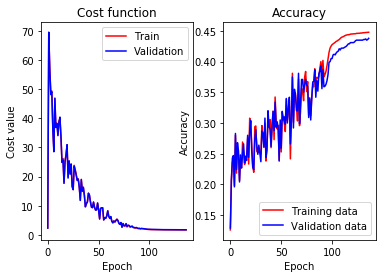

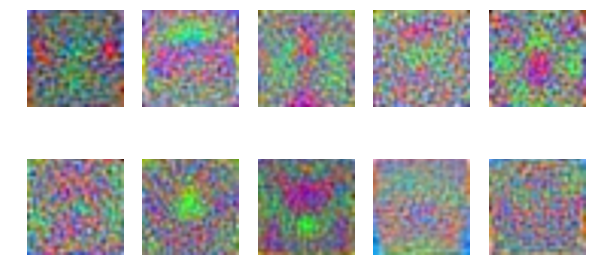

In [81]:
# Grid search
batch_sizes = [100, 500, 750, 1000, 2500, 5000]
lr_params = [(0.01, 1.0), (0.05, 0.2), (0.1, 0.1), (0.25, 0.04), (0.5, 0.02)] #learning rates along with decay rates
lamdas = [0.0, 0.1] # Regularization constant
n_epochs = 150 #No need for hyperparameter tuning since early stopping is used
patience = 15
max_accuracy = -1
max_accuracy_model = None
max_accuracy_params = None
max_accuracy_lists = None

for batch_size in batch_sizes:
    for eta, decay_rate in lr_params:
        for lamda in lamdas:
            GDparams = Params(n_batch = batch_size, eta = eta, n_epochs = n_epochspochs, decay_rate = decay_rate, patience = patience) 
            network_model = FeedforwardNet(d = X_tr.shape[1], K = Y_tr.shape[1], mean = 0.0, s = 0.01)
            tr_loss, val_loss, tr_accuracy, val_accuracy = network_model.miniBatchGD(X_tr, Y_tr, GDparams, lamda,
                                                            GDmethod = "analytical", verbose = False,
                                                            X_val = X_val, Y_val = Y_val)
            if(val_accuracy[-1] > max_accuracy):
                max_accuracy_model = network_model
                max_accuracy_params = GDparams
                max_accuracy = val_accuracy[-1]
                max_accuracy_lists = (tr_loss, val_loss, tr_accuracy, val_accuracy)
            print("BATCH: " + str(batch_size) + " ETA: " + str(eta) + " Lambda: " + str(lamda) + " ACCURACY " + str(val_accuracy[-1] ))
            print("FINAL EPOCH: " + str(len(val_accuracy)))
# Report final training, validation and test accuracies
print("ACCURACIES ACHIEVED AFTER TRAINING")
print("TRAINING ACCURACY: " + str(max_accuracy_lists[2][-1]))
print("VALIDATION ACCURACY: " + str(max_accuracy_lists[3][-1]))
print("TEST ACCURACY: " + str(max_accuracy_model.computeAccuracy(X_tst, y_tst)))
# Plot cost function values and accuracies achieved per epoch
makePlots(max_accuracy_lists[0], max_accuracy_lists[1], max_accuracy_lists[2], max_accuracy_lists[3])
# Visualize learned weights
visualizeWeights(max_accuracy_model)